## Volatility Forecasting & VaR in Crypto currencies

In [77]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random
import warnings
import statsmodels.api as sm

warnings.filterwarnings('ignore')

In [78]:
df = yf.download("BTC-USD", start="2020-01-01", end="2025-01-01", multi_level_index=False)['Close']


df.head()

[*********************100%***********************]  1 of 1 completed

Date
2020-01-01    7200.174316
2020-01-02    6985.470215
2020-01-03    7344.884277
2020-01-04    7410.656738
2020-01-05    7411.317383
Name: Close, dtype: float64

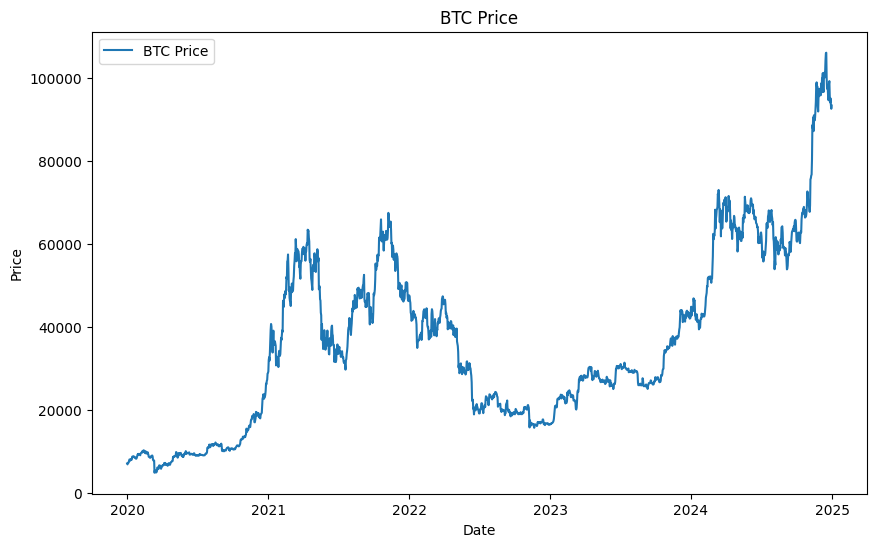

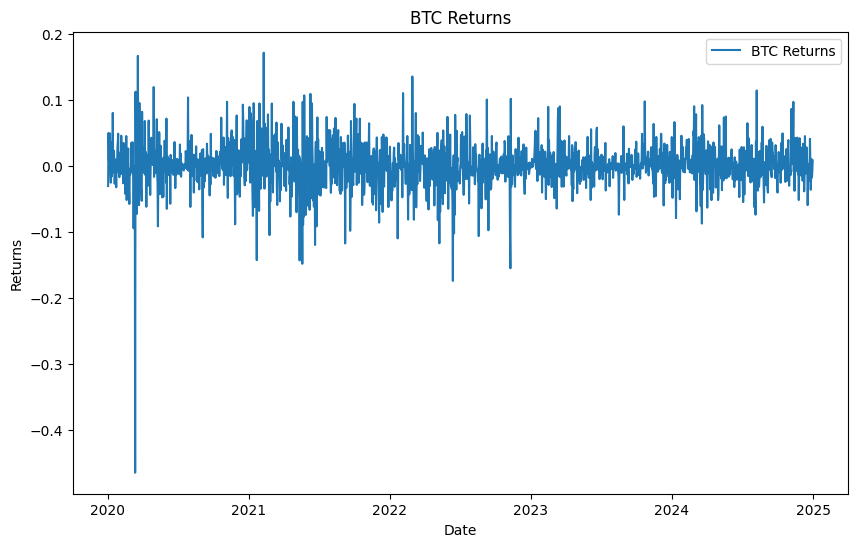

In [79]:
# Here we will plot both the graphs of the prices and the graphs for the returns (for returns I will be using the log returns)

plt.figure(figsize=(10, 6))
plt.plot(df, label='BTC Price')
plt.title('BTC Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()



df_returns = np.log(df/df.shift(1))
plt.figure(figsize=(10, 6))
plt.plot(df_returns, label='BTC Returns')
plt.title('BTC Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()


##### We can clearly see that the volatility follows the principle of volatility clustering, let us continue on this path

In [80]:
df_returns.fillna(0, inplace=True)

In [81]:
from arch import arch_model

model = arch_model(df_returns, vol='GARCH', p=1, o=0, q=1, dist='t')
result = model.fit()
print(result.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 29757.116575049356
Iteration:      2,   Func. Count:     20,   Neg. LLF: 69072.23633736848
Iteration:      3,   Func. Count:     33,   Neg. LLF: 15426.127006747656
Iteration:      4,   Func. Count:     45,   Neg. LLF: -3869.634309561994
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3869.6343097886456
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 4
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                3869.63
Distribution:      Standardized Student's t   AIC:                          -7729.27
Method:                  Maximum Likelihood   BIC:                         

#### We go with t distribution as it maximizes the LLF function and has the lowest AIC/BIC

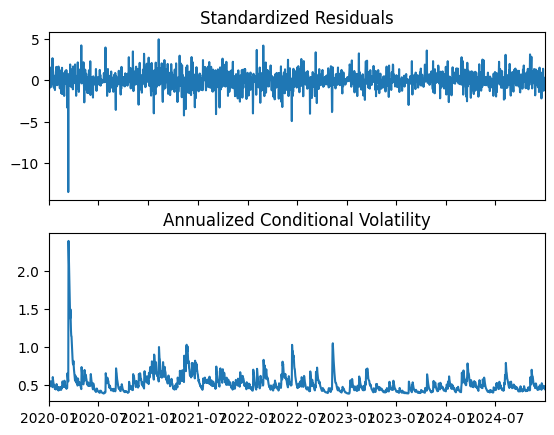

In [82]:
result.plot(annualize="D")
plt.show()

In [83]:
forecasts = result.forecast(horizon=1)
cond_vol = forecasts.variance.iloc[-1]**0.5

# Historical simulation style VaR
z_95 = np.percentile(result.std_resid, 5)   # 5% quantile
z_99 = np.percentile(result.std_resid, 1)   # 1% quantile

VaR_95 = cond_vol * z_95
VaR_99 = cond_vol * z_99

print(f"95% VaR: {VaR_95.values[0]*100:.2f}%")
print(f"99% VaR: {VaR_99.values[0]*100:.2f}%")


95% VaR: -4.20%
99% VaR: -7.44%


##### We are 95% sure we will not lose more than 4.18%, and we are 99% sure we will not lose more than 7.37% tomorrow!

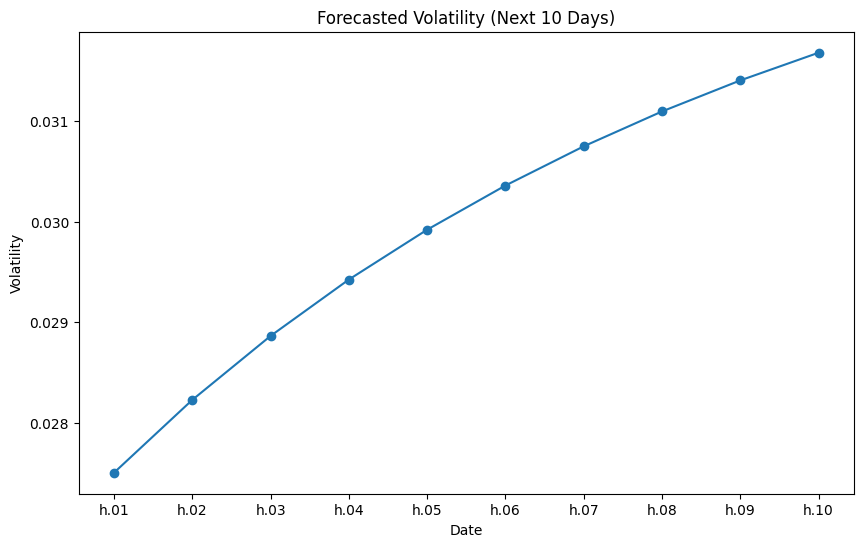

In [84]:
# Multiple-step forecast (say 10 days ahead)
forecasts = result.forecast(horizon=10)

# Extract conditional vol forecast
cond_vols = np.sqrt(forecasts.variance.iloc[-1])

plt.figure(figsize=(10,6))
plt.plot(cond_vols.index, cond_vols.values, marker='o')
plt.title("Forecasted Volatility (Next 10 Days)")
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.show()


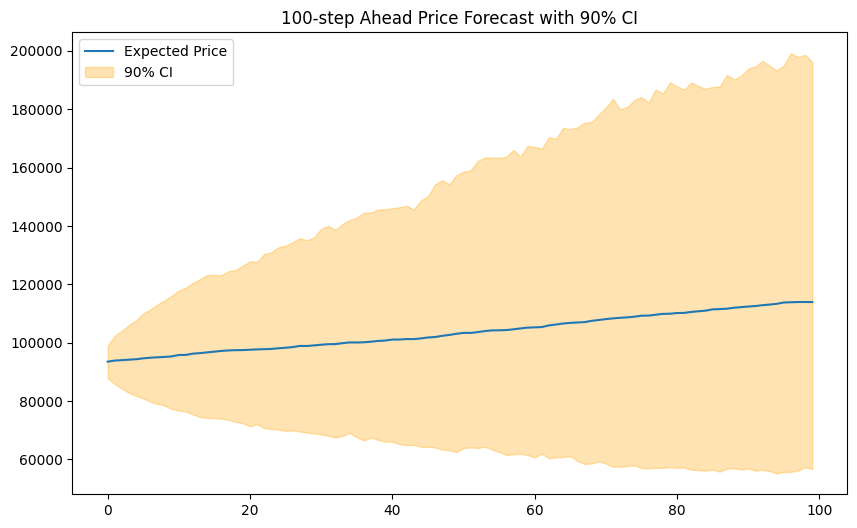

In [85]:
# assume result is your fitted GARCH model
T = 100  # forecast horizon
P0 = df_returns.index[-1]  # starting price
S0 = df[-1]  # last observed price

simulations = 1000  # Monte Carlo paths
price_paths = np.zeros((T, simulations))

for i in range(simulations):
    S = S0
    for t in range(T):
        sigma_t = np.sqrt(result.forecast(horizon=1).variance.values[-1,0])
        z = np.random.standard_t(df=result.params['nu'])  # if t-distribution
        r_t = result.params['mu'] + sigma_t * z
        S = S * np.exp(r_t)
        price_paths[t,i] = S

# Compute mean and confidence intervals
mean_path = price_paths.mean(axis=1)
lower = np.percentile(price_paths, 5, axis=1)
upper = np.percentile(price_paths, 95, axis=1)

# Plot
plt.figure(figsize=(10,6))
plt.plot(mean_path, label="Expected Price")
plt.fill_between(range(T), lower, upper, color='orange', alpha=0.3, label="90% CI")
plt.title("100-step Ahead Price Forecast with 90% CI")
plt.legend()
plt.show()
